In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import bambi
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy

# Over and Under Fitting

Details of estimation, after an estimator has been constructed. 

The estimator might exist, but not be useful

Sample is finite, getting efficient estimators is difficult. 

**Struggle against Causation**: How to use causal assumptions to design estimators, contrast alternative models

**Struggle against data**: How to make estimators work

## Problems of Prediction

- What function describes these points? (**fitting, compression**)

- What function explains the points? (**causal inference**)

- What would happen if we changed a point? (**intervention**)

- What is the next observation from the same process? (**prediction**)

## Leave-one-out cross-validation (LOO)

1) Drop one point
2) Fit line to remaining
3) Predict dropped point
4) Repeat (1) with next point
5) Score is error on dropped 

Do not compare on the In score, compare them on the Out score. 

Log pointwise predictive density (predictive distribution).

General intuition for simple models: Flexibility leads to lower In score, higher out score, Overfitting to the data and leading to increase in error on the out of sample. 

## Regularization

Overfitting depends upon the priors

Skeptical priors have tighter variance, reduce flexibility

**Regulatization**: Function finds regular features of process

Good priors are often tighter than you think.

Bayesian methods can use skeptical priors as one way to regularize. 

Want the model to learn regular features, but not learn irregular features. 

## Regularizing Priors

How to choose the width of prior

**Causal Inference**: Use science

**Prediction**: Tune the prior using cross-validation

Usually want to mix inference and prediction. 

## Prediction Penalty

For N points, cross-validation requires fitting N moddels

What if we could estimate the penalty from a single model?

We can using:

- Importance Sampling (PSIS)(Pareto Smoothed Importance Sampling)
- Information criteria (WAIC)

These measure overfitting while regularization manages overfitting **never pick a causal model based off these scores** 

## Model Mis-selection

Again, do not sue predictive cristeria to choose a causal estimate. (Causal estimate is prediction in presence of intervention)

Predictive criteria actually prefer confounds & colliders.

Conditioning on things like colliders and post treatment variables, actually improve predictive accuracy out of sample. 

However, if you want to only do predictive accuracy, then you can use predictive accuracy if you like. 

## Outliers and Robust Regression

Some points are more influential than others

**Outliers** : Observations in the tails of the predictive distribution

Outliers indicate predications are possible overconfident, unreliable

The model doesn't expect enough variation

Is the model mispecified? Not taking into account the info provided by the outliers?

Dropping outliers is bad: Just ignores the problem and still leads to bad predictions

Need to fix the model, not the data

### How to fix:

1) Need to quantify the influence of each point

2) Use a mixture model (robust regression)


In [2]:
divorce = pd.read_csv('Data/WaffleDivorce.csv',sep=';')
divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


<AxesSubplot: xlabel='MedianAgeMarriage', ylabel='Divorce'>

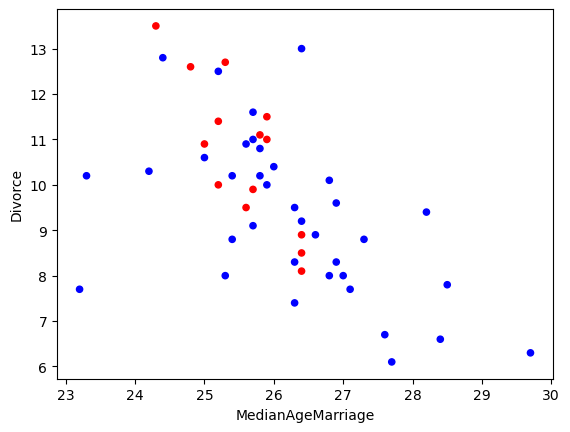

In [3]:
divorce.plot.scatter(x='MedianAgeMarriage',y='Divorce',c=divorce['South'].map({1:'red',0:'blue'}))

Maine and Idaho are both unusual

Maine: high divorce for trend

Idaho: Low divorce for trend 

Principled way to quantify outliers:

PSIS k statistic

## Mixing Gaussians

- Assert that the population is the result of a mix of gaussians

- When you mix gaussian distributions with the same mean, but different variances you get thicker tails. the Student-t distribution. 

## Student-t

G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


(-10.0, 10.0)

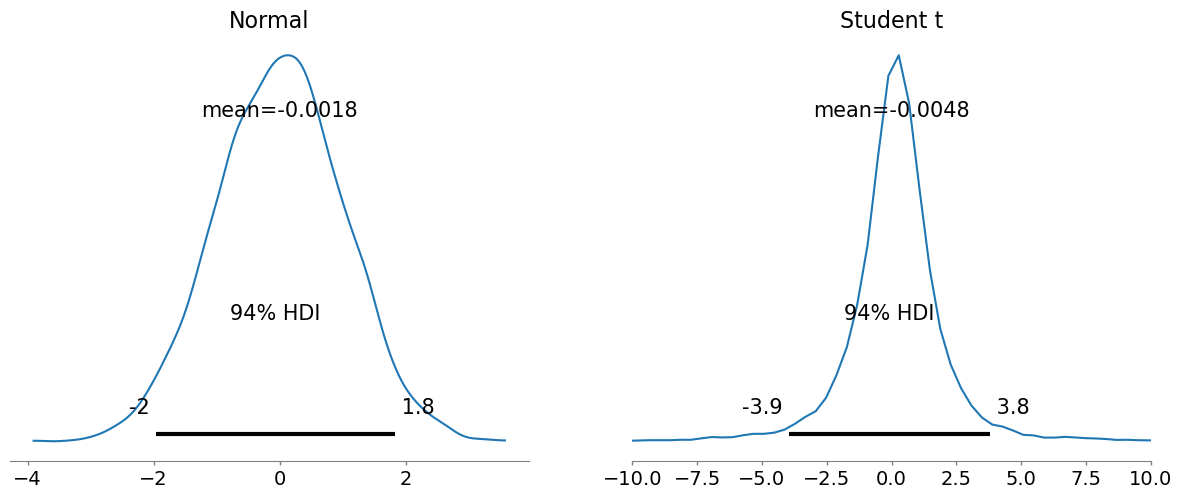

In [4]:
az.plot_posterior({'Normal': np.random.normal(size=10000),'Student t':np.random.standard_t(df=2, size = 10000)})
plt.xlim(-10,10)
#az.plot_posterior(np.random.standard_t(df=2, size = 10000))

Gaussian is very skeptical about anything outside of a few standard deviations

Student-t is a lot less perturbed by outliers, a lot less skeptical. 

In [5]:
A = scale(divorce['MedianAgeMarriage'])
D = scale(divorce['Divorce'])
M = scale(divorce['Marriage'])

In [6]:
with pm.Model() as n_model:
    sigma = pm.Exponential('sigma',1)
    bA    = pm.Normal('bA',0,0.5)
    bM    = pm.Normal('bM',0,0.5)
    a     = pm.Normal('a',0,0.5)
    
    mu = a + bM*M + bA*A
    
    Dmod = pm.Normal('D',mu,sigma,observed = D)
    
    n_sample = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [7]:
with pm.Model() as t_model:
    sigma = pm.Exponential('sigma',1)
    bA    = pm.Normal('bA',0,0.5)
    bM    = pm.Normal('bM',0,0.5)
    a     = pm.Normal('a',0,0.5)
    
    mu = a + bM*M + bA*A
    
    Dmod = pm.StudentT('D',mu=mu,sigma=sigma,nu=2,observed = D)
    
    t_sample = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<AxesSubplot: >

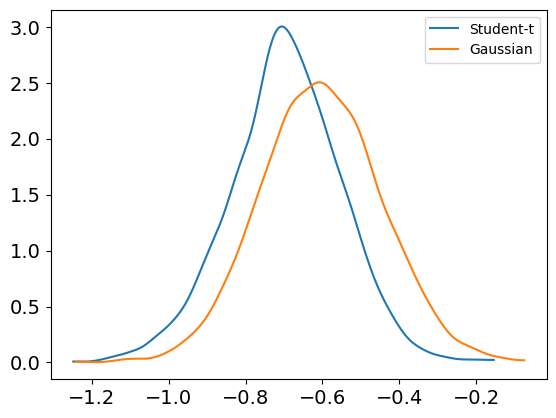

In [8]:
az.plot_dist(t_sample.posterior['bA'],color='C0',label='Student-t')
az.plot_dist(n_sample.posterior['bA'],color='C1',label='Gaussian')
#Note Student-t gives a stronger relationship

## Pareto smoothed importance sampling with pymc and arviz

In [10]:
with n_model:
    pm.compute_log_likelihood(n_sample,extend_inferencedata=True)
with t_model:
    pm.compute_log_likelihood(t_sample,extend_inferencedata=True)
az.loo(n_sample)

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -64.46     6.33
p_loo        4.83        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       49   98.0%
 (0.5, 0.7]   (ok)          1    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [11]:
az.loo(t_sample)

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -67.03     5.71
p_loo        6.30        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Robust Regressions
Unobserved heteogeneity => mixture of Gaussians

This tails means model is less surprised by sextreme values

Usually impossible to estimate distribution of extreme values
(just have to choose or simulate many and report all degrees of freedom for the student-t)

Processes with thick tails, the extreme sample are sstill rare but have big effects. 

Student-t regression is a good default for 'under theorized domains'. Gaussian can be too skeptical. 

## Problems of Prediction

What is the next observation from the same process? (prediction)

Possible to make very good predictions without knowing causes

Optimizing prediction does not reliably reveal causes

Powerful tools (PSIS, regularization) for measuring and managing accuracy. 